In [1]:
from data_processing import Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter
import numpy as np
from noise import NoiseScheduler
import torch
import torch.nn.functional as F
from jet_finding import *
import random
from tqdm.notebook import tqdm
random.seed(10)

if torch.cuda.is_available():
    print("CUDA is available!")
    print("Number of available GPUs:", torch.cuda.device_count())
    print("Current GPU:", torch.cuda.current_device())
else:
    print("CUDA is not available. Running on CPU.")

CUDA is available!
Number of available GPUs: 1
Current GPU: 0


In [2]:
data_dir = "Datasets" # Change directory where data is stored here
start_idx = 12000 # Adjust which events to look at from the dataset, make different to the training data 
end_idx = 12300
dataset = Dataset(10000, (120, 72), signal_file=f"{data_dir}/CaloImages_signal.root", pile_up_file=f"{data_dir}/CaloImages_bkg.root", save=False, start_idx=start_idx, end_idx=end_idx)

In [3]:
dataset() #once this is cached, you don't have to re-load

INFO:root:loading file Datasets/CaloImages_signal.root
loading file Datasets/CaloImages_signal.root
100%|██████████| 300/300 [00:00<00:00, 748.13it/s]


In [4]:
new_dim=(64,64)

saturation_value = 512 # Change saturation value here (make same as training value)
dataset.preprocess(saturation_value, new_dim)     # ensure these have the same values as when the model was trained

INFO:root:re-sizing
re-sizing


In [5]:
preprocess = transforms.Compose(
        [
            transforms.ToTensor()
        ]
)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
# Extract horizontal strip from y=26 to y=38 (12 pixels tall)
# Change how much of image to train model on here
strip_size = 'full_image'

if strip_size == 'full_image':
    y_start = 0
    y_end = 64

elif strip_size == 'strip':
    y_start = 26
    y_end = 38

In [8]:
clean_frames = preprocess(dataset.signal).float().permute(1, 2, 0).unsqueeze(1)[:, :, y_start:y_end, :].to(device) #pytorch symantics
pile_up = preprocess(dataset.pile_up).float().permute(1, 2, 0).unsqueeze(1)[:, :, y_start:y_end, :].to(device)

In [9]:
testEvent=10

noise_scheduler = NoiseScheduler('pile-up')
timestep = torch.LongTensor([40]).to(device) #each unit of timestep represents an addtional 5 pile-up events
random_seed = np.random.randint(0, end_idx-start_idx)
noisy_image, noise = noise_scheduler.add_noise(clean_frame=clean_frames[testEvent], noise_sample=pile_up, timestep=timestep, random_seed=random_seed, n_events = end_idx-start_idx)
noisy_image = torch.clamp(noisy_image, max=saturation_value)

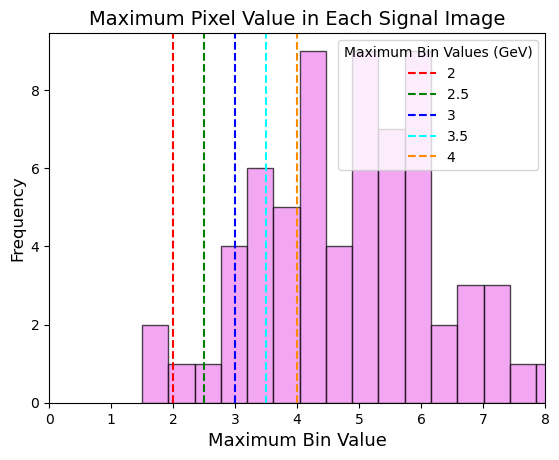

Threshold (GeV)      Perc of Events Above Threshold(%)
0.5                  100.00                   
1                    100.00                   
1.5                  99.67                    
2                    99.00                    
2.5                  98.67                    
3                    98.00                    
3.5                  95.67                    
4                    94.00                    
4.5                  90.67                    
5                    87.67                    


In [10]:
# Aside: calculate the maximum pixel value in each event loaded in the Dataset
max_bin = np.zeros(end_idx-start_idx)
for event in range(end_idx-start_idx):
    max_bin[event] = clean_frames[event].max().item()

# Plot histogram to see distribution of maximum pixel value in each event
plt.hist(max_bin, bins=1000, color='violet', alpha=0.7, edgecolor='black')
plt.title('Maximum Pixel Value in Each Signal Image', fontsize=14)
plt.xlabel('Maximum Bin Value', fontsize=13)
plt.ylabel('Frequency', fontsize=12)
thresholds = [2, 2.5, 3, 3.5, 4, 4.5, 5]
# Plot vertical lines at threshold values
plt.axvline(x=thresholds[0], color='r', linestyle='--', label=thresholds[0])
plt.axvline(x=thresholds[1], color='green', linestyle='--', label=thresholds[1])
plt.axvline(x=thresholds[2], color='blue', linestyle='--', label=thresholds[2])
plt.axvline(x=thresholds[3], color='cyan', linestyle='--', label=thresholds[3])
plt.axvline(x=thresholds[4], color='darkorange', linestyle='--', label=thresholds[4])
plt.xlim(0,8)

# Add legend
plt.legend(title='Maximum Bin Values (GeV)')
plt.show()

# Calculate the percentage of events with maximum pixel value greater than given thresholds
thresholds = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
percentages = [(max_bin > threshold).sum() / len(max_bin) * 100 for threshold in thresholds]

# Print the table
print(f"{'Threshold (GeV)':<20} {'Perc of Events Above Threshold(%)':<25}")
for threshold, percentage in zip(thresholds, percentages):
    print(f"{threshold:<20} {percentage:<25.2f}")

Text(0.5, 1.0, 'Clean Image Event 10')

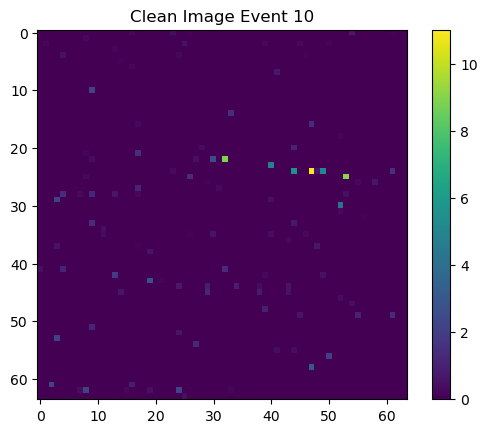

In [11]:
plt.imshow(clean_frames[testEvent].cpu().squeeze())
plt.colorbar()
plt.title(f"Clean Image Event {testEvent}")

Text(0.5, 1.0, 'Noisy Image Event 10')

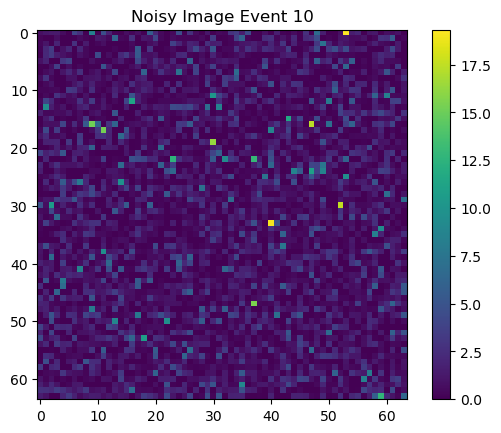

In [12]:
plt.imshow(noisy_image[0].cpu())
plt.colorbar()
plt.title(f"Noisy Image Event {testEvent}")


In [13]:
from models_stripped_kernels import Model, UNetLite_hls

modtype = 'UNet_lite' # Change Model type here

if modtype == 'UNet2d':
    model = Model('UNet', new_dim)
    model = model.__getitem__()

elif modtype == 'UNet_lite':
    model = UNetLite_hls()

# Move model to GPU
model = model.to(device)    

print(model)

c:\Users\Luke Johnson\Anaconda3\envs\sd_env\lib\site-packages\diffusers\models\transformers\transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


UNetLite_hls(
  (relu): ReLU()
  (pool): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (up): ConvTranspose2d(16, 16, kernel_size=(2, 2), stride=(2, 2))
  (emb1): Linear(in_features=4, out_features=1, bias=True)
  (convd1_1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (normd1_1): GroupNorm(8, 16, eps=1e-05, affine=True)
  (convd1_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (normd1_2): GroupNorm(8, 16, eps=1e-05, affine=True)
  (emb2): Linear(in_features=4, out_features=16, bias=True)
  (convd2_1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (normd2_1): GroupNorm(8, 16, eps=1e-05, affine=True)
  (convd2_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (normd2_2): GroupNorm(8, 16, eps=1e-05, affine=True)
  (emb4): Linear(in_features=4, out_features=16, bias=True)
  (convb1_1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (normb1_1): GroupNorm(8, 16, eps=1e-05, affine=Tru

In [14]:
if modtype == 'UNet2d':
    # Use 1st line for huggingface trained model
    # Use 2nd line for retrained model

    #trained_model_path = '/cephfs/dice/projects/L1T/diffusion/trained_models/trained_diffusor.pt'
    trained_model_path = 'retrained_models_UNet2d/saturation=512/model_epoch_9.pt'

elif modtype == 'UNet_lite': 
    trained_model_path = 'trained_models_lite/saturation=512/model_epoch_9.pt' # Specify folder for which trained model here!

print(trained_model_path)

trained_models_lite/saturation=512/model_epoch_9.pt


In [15]:
checkpoint = torch.load(trained_model_path, map_location=device)  # Ensure checkpoint is loaded to the correct device
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [16]:
if modtype == 'UNet2d':
    noise_pred = model(noisy_image.unsqueeze(1), timestep, return_dict=False)[0][0]
elif modtype == 'UNet_lite':
    noise_pred = model(noisy_image.unsqueeze(1), timestep)[0]

In [17]:
de_noised = F.relu(noisy_image[0].cpu() - (noise_pred[0].detach().cpu()))

Text(0.5, 1.0, 'Denoised Image Event 10')

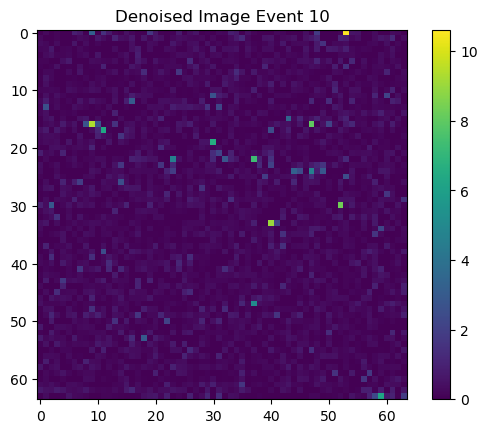

In [18]:
im = plt.imshow(de_noised)
plt.colorbar(im)
plt.title(f"Denoised Image Event {testEvent}")

In [19]:
clean_frames[testEvent][0]

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0926, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1521, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 2.2126,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')

In [20]:
local_maxima, jets_clean = find_local_maxima(clean_frames[testEvent][0].cpu(), 9)

In [21]:
print(local_maxima)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Number of local maxima:  3


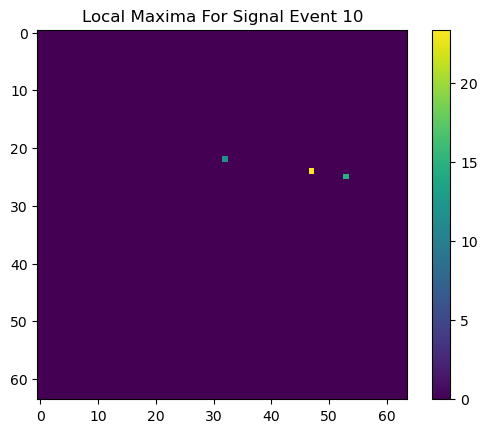

In [22]:
plt.imshow(local_maxima)
print('Number of local maxima: ', len(jets_clean))
plt.colorbar()
plt.title(f"Local Maxima For Signal Event {testEvent}")
plt.show()

Number of local maxima:  18


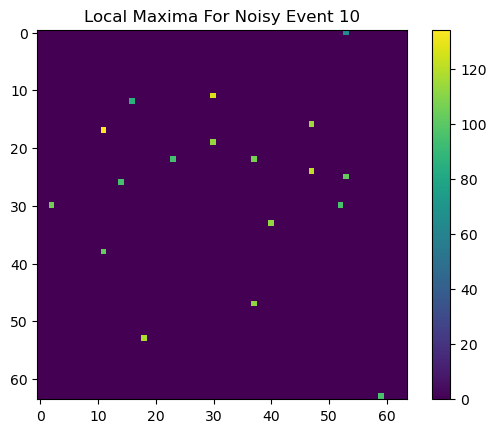

In [23]:
local_maxima, jets_noisy = find_local_maxima(noisy_image[0].cpu(), 9)
print ('Number of local maxima: ', len(jets_noisy))
plt.imshow(local_maxima)
plt.colorbar()
plt.title(f"Local Maxima For Noisy Event {testEvent}")
plt.show()

Number of local maxima:  9


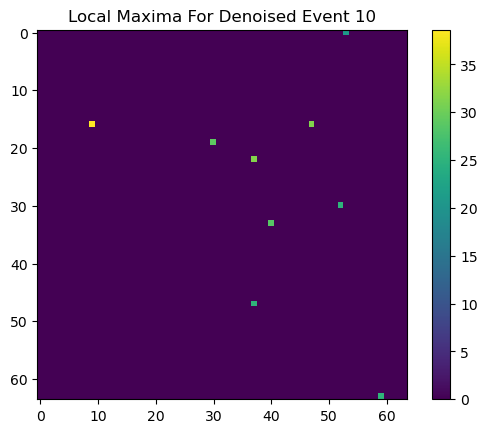

In [24]:

local_maxima, jets_denoised = find_local_maxima(de_noised, 9)
print ('Number of local maxima: ', len(jets_denoised))
plt.imshow(local_maxima)
plt.colorbar()
plt.title(f"Local Maxima For Denoised Event {testEvent}")
plt.show()

In [25]:
print (jets_denoised)

[{'i': 0, 'j': 53, 'pixel_value': tensor(10.6196), 'sum_around_maxima': 21.254673}, {'i': 16, 'j': 9, 'pixel_value': tensor(9.3169), 'sum_around_maxima': 38.640175}, {'i': 16, 'j': 47, 'pixel_value': tensor(8.0163), 'sum_around_maxima': 31.311777}, {'i': 19, 'j': 30, 'pixel_value': tensor(6.5786), 'sum_around_maxima': 29.049849}, {'i': 22, 'j': 37, 'pixel_value': tensor(7.3419), 'sum_around_maxima': 31.45259}, {'i': 30, 'j': 52, 'pixel_value': tensor(8.3267), 'sum_around_maxima': 25.113716}, {'i': 33, 'j': 40, 'pixel_value': tensor(9.0162), 'sum_around_maxima': 28.646885}, {'i': 47, 'j': 37, 'pixel_value': tensor(5.1427), 'sum_around_maxima': 25.271313}, {'i': 63, 'j': 59, 'pixel_value': tensor(6.2276), 'sum_around_maxima': 25.22871}]


Reference Maxima: {'i': 24, 'j': 47, 'pixel_value': tensor(11.0282), 'sum_around_maxima': 23.350328}, Test Maxima: {'i': 24, 'j': 47, 'pixel_value': tensor(11.0282), 'sum_around_maxima': 121.238815}
Reference Maxima: {'i': 25, 'j': 53, 'pixel_value': tensor(9.0656), 'sum_around_maxima': 14.822347}, Test Maxima: {'i': 25, 'j': 53, 'pixel_value': tensor(9.5593), 'sum_around_maxima': 102.237915}


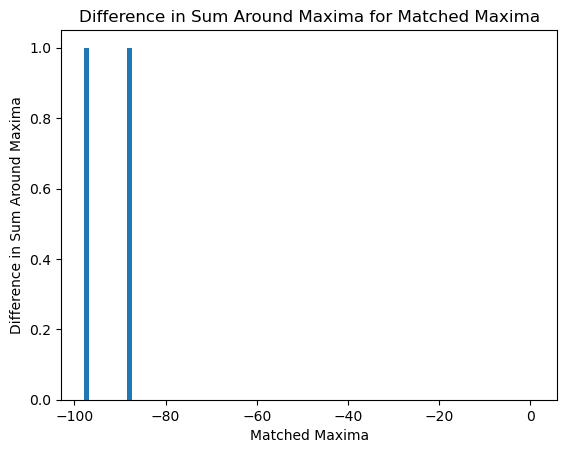

In [26]:
differences_allJetTypes = []
for test_jets in [ jets_noisy, jets_denoised ]:
    matching_jets = find_matching_maxima(jets_clean,test_jets)
    for ref_maxima, test_maxima_entry in matching_jets:
        print(f"Reference Maxima: {ref_maxima}, Test Maxima: {test_maxima_entry}")

    differences = [ref_maxima['sum_around_maxima'] - test_maxima_entry['sum_around_maxima']
                for ref_maxima, test_maxima_entry in matching_jets]
    differences_allJetTypes.append(differences)

    plt.hist(differences)

plt.xlabel('Matched Maxima')
plt.ylabel('Difference in Sum Around Maxima')
plt.title('Difference in Sum Around Maxima for Matched Maxima')
plt.show()
# # Example usage:
# # Assuming reference_maxima and test_maxima are your lists of maxima positions
# reference_maxima = [...]  # Your list of maxima from the reference
# test_maxima = [...]       # Your list of maxima from the test

# # Find matching maxima
# matching_maxima = find_matching_maxima(reference_maxima, test_maxima)

# # Display the matching maxima
# print("Matching Maxima:")
# for ref_maxima, test_maxima_entry in matching_maxima:
#     print(f"Reference Maxima: {ref_maxima}, Test Maxima: {test_maxima_entry}")

In [27]:
differences_allJetTypes = []
differences_jets_noisy = []
differences_jets_denoised = []
differences_jets_denoised_partial = []

progress_bar = tqdm(total=end_idx-start_idx)
progress_bar.set_description("Progress")

for event in range(end_idx-start_idx):
    noise_scheduler = NoiseScheduler('pile-up')
    timestep = torch.LongTensor([40]).to(device) #each unit of timestep represents an addtional 5 pile-up events
    random_seed = np.random.randint(0, end_idx-start_idx)

    noisy_image, noise = noise_scheduler.add_noise(clean_frame=clean_frames[event], noise_sample=pile_up, timestep=timestep, random_seed=random_seed, n_events = end_idx-start_idx)
    noisy_image = torch.clamp(noisy_image, max=saturation_value)

    if modtype == 'UNet2d':
        noise_pred = model(noisy_image.unsqueeze(1), timestep, return_dict=False)[0][0]
    elif modtype == 'UNet_lite':
        noise_pred = model(noisy_image.unsqueeze(1), timestep)[0]
    
    de_noised = F.relu(noisy_image[0].cpu() - (noise_pred[0].detach().cpu()))

    noisy_image_partial, noise_partial = noise_scheduler.add_noise(clean_frame=clean_frames[event], noise_sample=pile_up, timestep=timestep, random_seed=random_seed, n_events = end_idx-start_idx)
    if modtype == 'UNet2d':
        noise_pred_partial = model(noisy_image_partial.unsqueeze(1), torch.LongTensor([1]).to(device), return_dict=False)[0][0]
    elif modtype == 'UNet_lite':
        noise_pred_partial = model(noisy_image_partial.unsqueeze(1), torch.LongTensor([1]).to(device))[0]

    de_noised_partial = F.relu(noisy_image_partial[0].cpu() - (noise_pred_partial[0].detach().cpu()))


    local_maxima, jets_clean = find_local_maxima(clean_frames[event][0].cpu(), 9)
    local_maxima, jets_noisy = find_local_maxima(noisy_image[0].cpu(), 9)
    local_maxima, jets_denoised = find_local_maxima(de_noised, 9)
    local_maxima, jets_denoised_partial = find_local_maxima(de_noised_partial, 9)
    
    matching_jets_noisy = find_matching_maxima(jets_clean,jets_noisy)
    matching_jets_denoised = find_matching_maxima(jets_clean,jets_denoised)
    matching_jets_denoised_partial = find_matching_maxima(jets_clean,jets_denoised_partial)

    differences_jets_noisy.extend([ref_maxima['sum_around_maxima'] - test_maxima_entry['sum_around_maxima']
                    for ref_maxima, test_maxima_entry in matching_jets_noisy])
    differences_jets_denoised.extend([ref_maxima['sum_around_maxima'] - test_maxima_entry['sum_around_maxima']
                    for ref_maxima, test_maxima_entry in matching_jets_denoised])
    differences_jets_denoised_partial.extend([ref_maxima['sum_around_maxima'] - test_maxima_entry['sum_around_maxima']
                    for ref_maxima, test_maxima_entry in matching_jets_denoised_partial])
    
    progress_bar.update(1)
    logs = {"Event": event}
    progress_bar.set_postfix(**logs)


    ## Use this code to test the thresholds visually compare the local maxima detection.  Use ctrl + / 
    # fig, axs = plt.subplots(1, 4, figsize=(32,6))

    # im0 = axs[0].imshow(clean_frames[event].cpu().squeeze())
    # axs[0].set_title(f"Clean Image Event {event}")
    # fig.colorbar(im0, ax=axs[0])

    # local_maxima, jets_clean = find_local_maxima(clean_frames[event][0].cpu(), 9)
    # im1 = axs[1].imshow(local_maxima)
    # axs[1].set_title(f"Local Maxima For Signal Event {event}")
    # fig.colorbar(im1, ax=axs[1])

    # im2 = axs[2].imshow(de_noised)
    # axs[2].set_title(f"Denoised Image Event {event}")
    # fig.colorbar(im2, ax=axs[2])

    # local_maxima_denoised, jets_denoised = find_local_maxima(de_noised, 9)
    # im3 = axs[3].imshow(local_maxima_denoised)
    # axs[3].set_title(f"Local Maxima For Denoised Event {event}")
    # fig.colorbar(im3, ax=axs[3])
    # plt.show()

  0%|          | 0/300 [00:00<?, ?it/s]

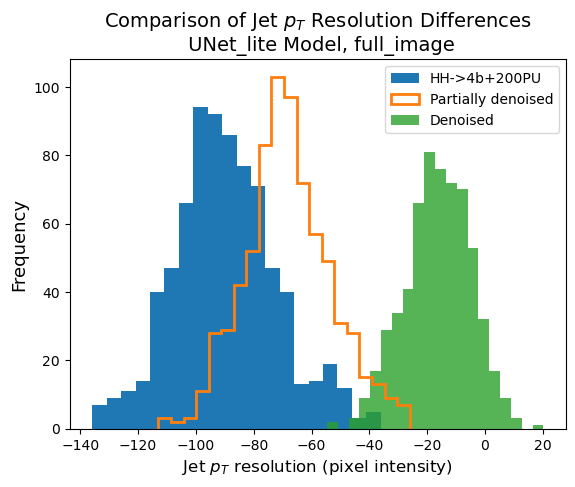

In [28]:
plt.hist(differences_jets_noisy, bins=20, label='HH->4b+200PU')
plt.hist(differences_jets_denoised_partial, bins=20, label='Partially denoised', histtype='step', linewidth=2)
plt.hist(differences_jets_denoised, bins=20, label='Denoised', alpha=0.8)
plt.title(f'Comparison of Jet $p_T$ Resolution Differences \n {modtype} Model, {strip_size}', fontsize=14)
plt.xlabel('Jet $p_T$ resolution (pixel intensity)', fontsize=12)
plt.ylabel('Frequency', fontsize=13)
plt.legend()
plt.show()


In [29]:
print (differences_jets_denoised)

[-24.066284, -15.561684, -6.467766, -22.239334, -23.597775, -28.126709, -10.903122, -13.576302, -27.96408, -12.039162, -23.658379, -4.7542973, -14.082123, 7.1747437, -17.46035, -18.052605, -16.710953, -30.462305, -16.944748, -5.3428764, -20.118244, -18.408539, -19.782234, -20.53888, -23.967194, -37.04309, -17.782082, -6.8379183, -11.885078, -22.178337, -18.48262, -15.422462, -16.656485, -7.4252815, -6.6323996, -6.273507, -4.8379555, -35.06601, -36.087234, -29.093079, -21.772488, -35.887825, -24.267666, -23.528332, -24.873013, -16.04567, -25.556435, -28.39653, -27.178413, -8.467964, -23.351486, -17.767563, -35.569534, -20.703125, -22.058067, -22.235275, -26.251648, -25.028183, -19.787628, -22.599403, -18.178082, -17.549599, -21.059128, -32.513428, -36.63965, -8.988056, -6.2482567, -26.008194, -33.005142, -15.599442, -24.753235, -20.777542, -40.420296, 0.520031, -22.550537, -28.859085, 0.395298, -7.685726, -24.31646, -17.025776, 7.107048, -14.762737, -18.115593, -7.898178, -7.3078346, -1